In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [186]:
features = pd.read_csv('Features data set.csv')
sales = pd.read_csv('sales data-set.csv')
stores = pd.read_csv('stores data-set.csv')

## 1- Plot weekly sales for each year

In [242]:
sales['Year'] = pd.to_datetime(sales['Date'], format='%d/%m/%Y').dt.year

sales['n_of_Week'] = pd.to_datetime(sales['Date'], format='%d/%m/%Y').dt.week

sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,n_of_Week
0,1,1,05/02/2010,24924.50,False,2010,5
1,1,1,12/02/2010,46039.49,True,2010,6
2,1,1,19/02/2010,41595.55,False,2010,7
3,1,1,26/02/2010,19403.54,False,2010,8
4,1,1,05/03/2010,21827.90,False,2010,9


In [188]:
year_list = []

for year in sales['Year'].unique():
    sales_per_year = sales[sales['Year']==year]['Weekly_Sales'].groupby(sales['n_of_Week']).sum().reset_index()
    year_list.append(sales_per_year)

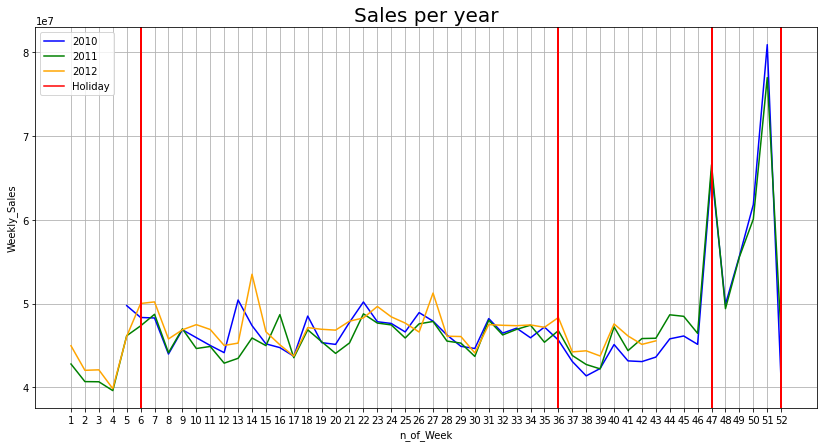

In [241]:
import seaborn as sns

plt.figure(figsize=(14,7))

colors = ['blue','green','orange']

for i in range(len(year_list)):
    sns.lineplot(x = 'n_of_Week', y = 'Weekly_Sales', data = year_list[i], color = colors[i])

    
holiday = sales['n_of_Week'].values[(sales['IsHoliday'])]

for holiday_week in holiday:
    plt.axvline(holiday_week, color='red')

plt.title('Sales per year', fontsize=20)
plt.grid()
plt.xticks(np.arange(1,53,1))

labels = [year for year in sales['Year'].unique()]
labels.append('Holiday')

plt.legend(labels = labels)
plt.show()

## 2- Predict the department-wide sales for each store for the following year

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year
0,1,1,05/02/2010,24924.50,False,2010
1,1,1,12/02/2010,46039.49,True,2010
2,1,1,19/02/2010,41595.55,False,2010
3,1,1,26/02/2010,19403.54,False,2010
4,1,1,05/03/2010,21827.90,False,2010


In [57]:
#Predict weekly sales

train_df = sales.copy()

test_df = sales.drop('Weekly_Sales', axis=1)
